<a href="https://colab.research.google.com/github/Pentuhov/PR-AI5/blob/main/%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%B8_%D0%BE%D0%B4%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D1%8B%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%94%D0%97_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам. Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий
заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва. Добейтесь правильного распознавания 6 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip

In [1]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [2]:
# Скачаем архив с симптомами болезней
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip', None, quiet=True)

'diseases.zip'

In [3]:
# Распакум архив
!unzip -o diseases.zip

Archive:  diseases.zip
   creating: dis/
  inflating: dis/Аппендицит.txt  
  inflating: dis/Гастрит.txt  
  inflating: dis/Гепатит.txt  
  inflating: dis/Дуоденит.txt  
  inflating: dis/Колит.txt      
  inflating: dis/Панкреатит.txt  
  inflating: dis/Холицестит.txt  
  inflating: dis/Эзофагит.txt  
  inflating: dis/Энтерит.txt  
  inflating: dis/Язва.txt        


In [4]:
FILE_DIR  = 'dis/'                     # Папка с текстовыми файлами

In [5]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла

    if ext=='txt':                                         # Если расширение txt то берем файл в работу
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку



Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"
Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"
Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"


In [6]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST)

In [7]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [8]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Эзофагит
  train: затруднения и болезненные ощущения при глотании изжога боли во рту ощущения чего-то застрявшего в горле тошнота рвота  боль при глотании и в состоянии покоя жжение изжога ком в горле болезненные ощущения во рту  неприятный привкус охриплость язвы во рту боль не только в пищеводе и в грудине, отдающая в спину неприятный запах изо рта  затруднённое прохождение пищи по пищеводу  может повышаться температура тела общее недомогание неприятные ощущения по ходу пищевода во время продвижения пищи может беспокоить жжение иногда резкая боль в пищеводе боль в области шеи отрыжка слюнотечение нарушается глотание  боли за грудиной и в подложечной области сочетается с гастритом или дуоденитом чувство саднения за грудиной непосредственно после проглатывания пищи боли, не зависящие от приёма пищи изжога вечером и ночью тошнота рвота икота слюнотечение затрудненное дыхание Икота   дисфагия (затрудненное и болезненное глотание) изжога ощущение кома в горле тошнота срыгивание съе

In [9]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [ ]:
#ваше решение

In [13]:
# Импорт необходимых библиотек
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Токенизация текстов
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text_train + text_test)

# Преобразование текстов в последовательности
X_train_seq = tokenizer.texts_to_sequences(text_train)
X_test_seq = tokenizer.texts_to_sequences(text_test)

# Паддинг последовательностей
max_length = max(max(len(x) for x in X_train_seq), max(len(x) for x in X_test_seq))
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_length)

# Кодирование классов
y_train = to_categorical(np.arange(CLASS_COUNT), num_classes=CLASS_COUNT)
y_test = to_categorical(np.arange(CLASS_COUNT), num_classes=CLASS_COUNT)

# Проверка формы входных данных
print(f'Форма обучающих данных: {X_train_pad.shape}, форма тестовых данных: {X_test_pad.shape}')

Форма обучающих данных: (10, 948), форма тестовых данных: (10, 948)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D

# Создание модели
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=128))  # Убираем input_length
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_COUNT, activation='softmax'))

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Обучение модели
history = model.fit(X_train_pad, y_train, epochs=25, batch_size=16, validation_data=(X_test_pad, y_test))

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0000e+00 - loss: 2.3278 - val_accuracy: 0.1000 - val_loss: 2.3024
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2000 - loss: 2.2936 - val_accuracy: 0.1000 - val_loss: 2.3024
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.0000e+00 - loss: 2.2908 - val_accuracy: 0.1000 - val_loss: 2.3020
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3000 - loss: 2.2655 - val_accuracy: 0.1000 - val_loss: 2.3013
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3000 - loss: 2.2561 - val_accuracy: 0.1000 - val_loss: 2.3004
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3000 - loss: 2.2619 - val_accuracy: 0.1000 - val_loss: 2.2991
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2000 - loss: 2.2540 - val_accuracy: 0.1000 - val_loss: 2.2981
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2000 - loss: 2.2573 - val_accuracy: 0.1000 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1000 - loss: 2.2893
Точность на тестовом наборе: 10.00%


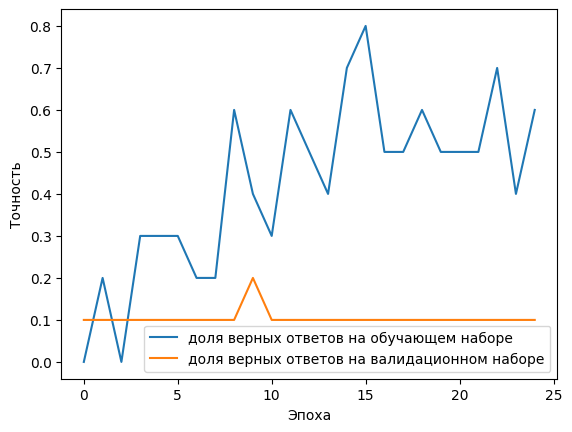

In [17]:
import matplotlib.pyplot as plt

# Оценка точности
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Точность на тестовом наборе: {accuracy * 100:.2f}%')

# Визуализация результатов
plt.plot(history.history['accuracy'], label='доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='доля верных ответов на валидационном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


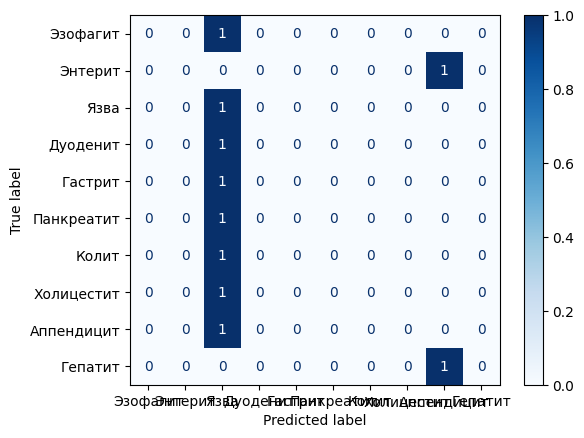

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Получаем предсказания
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Получаем действительные метки
y_true = np.argmax(y_test, axis=1)

# Строим матрицу ошибок
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
disp.plot(cmap=plt.cm.Blues)
plt.show()